# Radio Light Curve

## COMPAS
* HP (https://compas.science/)
* GitHub (https://compas.readthedocs.io/en/latest/)
* Patameter List (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification.html)
    * Stellar Properties (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification-stellar.html)
    * Binary Properties (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification-binary.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import seaborn as sns
from scipy.interpolate import interp1d

import pickle
import bisect
import os
import glob

import h5py as h5
from astropy.table import  unique, vstack, Table, Column, join
import astropy.units as u
from astropy import constants as const
from scipy.stats import norm as NormDist
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

# Chosen cosmology 
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

import sys

##############################
# This path points to the COMPAS functions in your local folder,
# I've redefined most in this notebook anyway, but I was lazy w.r.t the kroupa IMF etc. 
sys.path.insert(0,'/home/jovyan/home/code/COMPAS/compas_python_utils/CosmicIntegration_vanSon/')

import FastCosmicIntegration as COMPAS_sfrd
import ClassCOMPAS as COMPAS_class

from importlib import reload  # Python 3.4+
reload(COMPAS_sfrd)

<module 'FastCosmicIntegration' from '/home/jovyan/home/code/COMPAS/compas_python_utils/CosmicIntegration_vanSon/FastCosmicIntegration.py'>

## PLOT setttings

In [2]:
######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

color_list = ['black', 'grey', '#4FC1E8', '#ed6c55', '#A0D568', '#FFCE54', '#6e6e6e']

## Constant Parameters

In [3]:
# physical constants
G = 6.67428e-8 # Gravitational Constant (dyn cm^2 / g^2)
c = 2.99792458e10 # Light Speed (cm/s)

# mass [g]
mp =  1.673e-24 # Proton Mass
me = 9.1093837015e-28 # Electron Mass
 
# solar quantities
sigma = 5.67e-5 #Stefan-Boltzmann Constant (erg/cm^2/K^4/s)
Msun = 1.99e33 # Solar Mass [g]
Lsun = 3.839e33 # Solar Luminosity [erg/s]
Rsun = 6.955e10 # Solar Radius [cm]
Tsun = (Lsun / (4*np.pi*Rsun**2*sigma))**0.25 # Solar Photospheric Temperature [K]
Zsun = 0.014 # Solar Metallicity

# time [s]
hr = 3600.0 # Hour
day = 24.0*hr # Day
yr =  365.25*day # Year
Myr = 1e6*yr # Mega Year
Gyr = 1e9*yr # Giga Year

# distance [cm]
pc = 3.086e18 # Parsec
Mpc = 1e6*pc # Mega Parsec
Gpc = 1e9*pc # Giga Parsec

q = 4.80320425e-10 
r_e = (q**2/(me*c**2))
sigT = (8.*np.pi/3.) * r_e**2

# frequency [Hz]
MHz = 1e6 # Mega Hertz
GHz = 1e9 # Giga Hertz

# radiation [erg/s/cm^2/Hz]
Jy = 1e-23 # Jansky
mJy = 1e-6 * Jy # Milli Jansky
uJy = 1e-9 * Jy # Micro Jansky

In [4]:
# parameter range (check the consistency with Hypernebula.py)
t = 0.1*(1.0+10**np.linspace(-2,7.5,1200)) #yr
nu = 1e9 * 10**np.linspace(-3.0,3.2,120) #Hz

# Central frequency of survey
nu_vlass = 3*GHz
nu_lotss = 140*MHz
nu_vlite = 350*MHz
nu_vast = 880*MHz
nu_thunderkat = 1.28*GHz
nu_dsa = 1*GHz

# Limiting sensitivity
fnu_vlass = 700*uJy
fnu_lotss = 95*uJy
fnu_vlite = 7000*uJy
fnu_vast = 240*uJy
fnu_thunderkat = 100*uJy
fnu_dsa = 10*uJy

# Sky coverage
cov_vlass = 34000/41252
cov_lotss = 40000/41252
cov_vlite = 40000/41252
cov_vast = 10000/41252
cov_thunderkat = 40000/41252
cov_dsa = 30000/41252

In [5]:
def tabobj_to_array(table_object):
    """
    smoothing function
    Args:
        table_object --> [list of objects] list of objects in Astropy Table
        
    Returns:
        result_array --> [list of floats]  float list
    """     
    
    # the object list converts into 1d array
    flattened_data = [element for sublist in table_object for element in sublist]
    # convert float array
    result_array = np.array(flattened_data)
    
    return result_array

In [6]:
def smooth(y, box_pts=20):
    """
    smoothing function
    Args:
        y        --> [list of floats]  list of values to be smoothed
        box_pts  --> [int]             box size of smoothing
        
    Returns:
        y_smooth --> [list of floats]  smoothed values
    """ 
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [7]:
def nuLnu (data, nu_survey, time):
    """
    calculate nuLnu
    Args:
        data       --> [dict]            output of Hypernebula.py
        nu_survey  --> [int]             central frequency of the survey
        time       --> [list of floats]  time adjusting the light curve duration
        
    Returns:
        nuLnu      --> [list of floats]  interpolated nuLnu
    """ 
    
    #initialization
    nuLnu = []
    for i in range(len(time)):
        
        # interpolation
        Lnu_interp = interp1d(nu, data['Lnu_syn'][i], kind='linear', fill_value="extrapolate")
        Lnu_GHz = Lnu_interp(nu_survey)
        nuLnu.append(Lnu_GHz * nu_survey)

    return nuLnu

In [8]:
def read_lc (dir_path):
    """
    Read the output files by Hypernebula.py
    Args:
        dir_path --> [char]          path to the output directly of Hypernebula.py
        
    Returns:
        lc_table --> [Astropy Table] Astropy table including 'Mdot', 't_active', and 'nuLnu' for each surveys
    """ 
    
    # make the file name list
    pkl_files = glob.glob(os.path.join(dir_path, '*.pkl'))    
    
    # initialization
    Mdot = []
    t_active = []
    v_w = []
    v_j = []
    epsilon_e = []
    sigma = []
    eta = []
    
    lc_vlass = []
    lc_lotss = []
    lc_vlite = []
    lc_vast = []
    lc_thunderkat = []
    lc_dsa = []

    for file_path in pkl_files:
        with open(file_path, 'rb') as file:
            try:
                loaddata = pickle.load(file)
                
                Mdot.append(loaddata['params']['Mdot_w'])
                t_active.append(loaddata['params']['t_active'])
                v_w.append(loaddata['params']['v_w'])
                v_j.append(loaddata['params']['v_j'])
                epsilon_e.append(loaddata['params']['epsilon_e'])
                sigma.append(loaddata['params']['sigma'])
                eta.append(loaddata['params']['eta'])
                
                time = t[t <= 100*loaddata['params']['t_active']]
                lc_vlass.append(nuLnu(loaddata, nu_vlass, time))
                lc_lotss.append(nuLnu(loaddata, nu_lotss, time))
                lc_vlite.append(nuLnu(loaddata, nu_vlite, time))
                lc_vast.append(nuLnu(loaddata, nu_vast, time))
                lc_thunderkat.append(nuLnu(loaddata, nu_thunderkat, time))
                lc_dsa.append(nuLnu(loaddata, nu_dsa, time))
                    
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                
    data_dicts = [{'Mdot': param1, 't_active': param2, 'v_w': param3, 'v_j': param4, 
                   'epsilon_e': param5, 'sigma':param6, 'eta': param7,
                   'vlass': lc1, 'lotss': lc2, 'vlite': lc3, 'vast': lc4, 'thunderkat': lc5, 'dsa': lc6} 
                  for param1, param2, param3, param4, param5, param6, param7, lc1, lc2, lc3, lc4, lc5, lc6 in 
                  zip(Mdot, t_active, v_w, v_j, epsilon_e, sigma, eta, 
                      lc_vlass, lc_lotss, lc_vlite, lc_vast, lc_thunderkat, lc_dsa)]
    
    data = pd.DataFrame(data_dicts) #.sort_values(by=['Mdot', 't_active']).reset_index(drop=True)
    lc_table = Table.from_pandas(data)
    
    return lc_table

In [12]:
dir_path_01_01 = './models/003_01_01_01_01'
lc_table_01_01 = read_lc(dir_path_01_01)

In [13]:
dir_path_025_01 = './models/003_025_01_01_01'
lc_table_025_01 = read_lc(dir_path_025_01)

## Plot

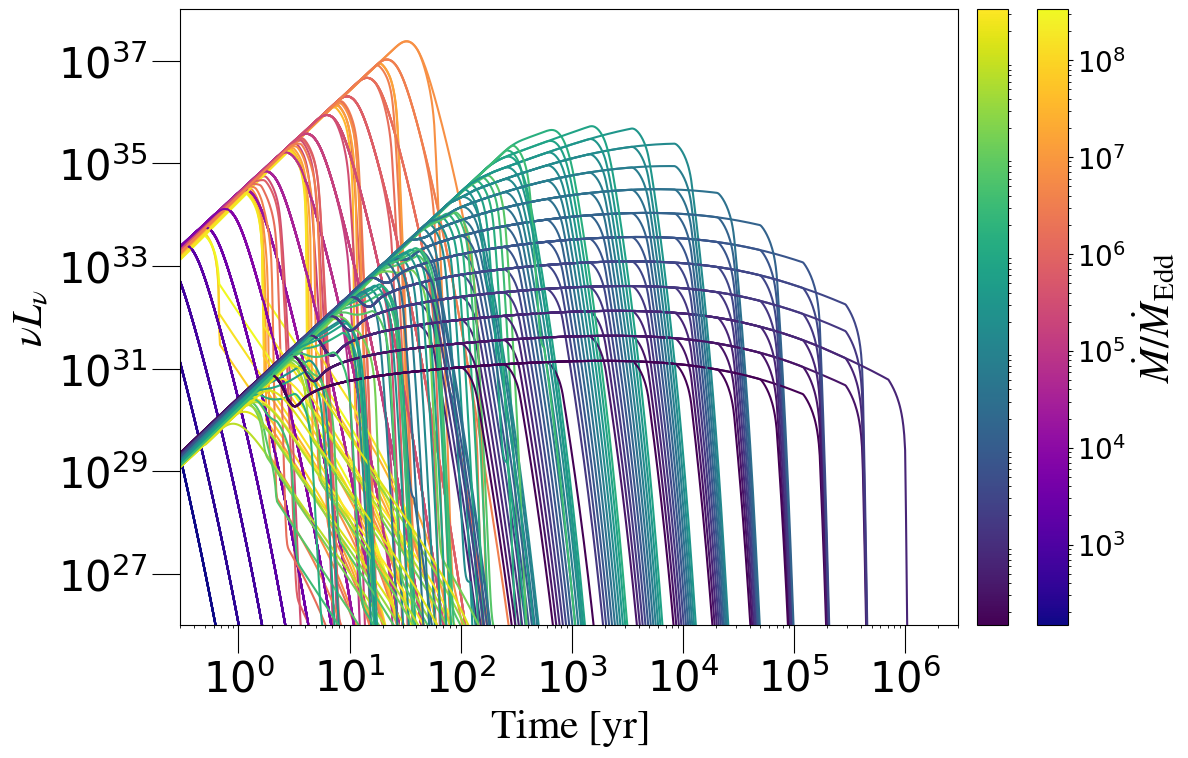

In [10]:
fig, ax = plt.subplots(figsize = (13,8))

color_values = lc_table_01_01['Mdot']
cmap1 = plt.get_cmap('plasma')
cmap2 = plt.get_cmap('viridis')
norm = LogNorm(vmin=min(color_values), vmax=max(color_values))

lines1 = []
for i in range(len(lc_table_01_01)):
    line, =ax.plot(t[t <= 100*lc_table_01_01[i]['t_active']], smooth(lc_table_01_01[i]['vlass']),
                    color=cmap1(norm(color_values[i])))
    lines1.append(line)
    
lines2 = []
for i in range(len(lc_table_01_01)):
    line, =ax.plot(t[t <= 100*lc_table_01_01[i]['t_active']], smooth(lc_table_01_01[i]['lotss']),
                    color=cmap2(norm(color_values[i])))
    lines2.append(line)

sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax, pad=-0.08)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label=r'$\dot{M}/\dot{M}_{\mathrm{Edd}}$', fontsize=30)

sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax, pad=0.02)
cbar2.set_ticks([])

ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.xscale('log')
plt.yscale('log')

plt.xlim([3e-1, 3e6])
plt.ylim([1e26, 1e38])

plt.xlabel(r'$\mathrm{Time \ [yr]}$', fontsize = 30)
plt.ylabel(r'$\nu L_{\nu}$', fontsize = 30)
plt.savefig('./figures/nuLnu_01_01_comp.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

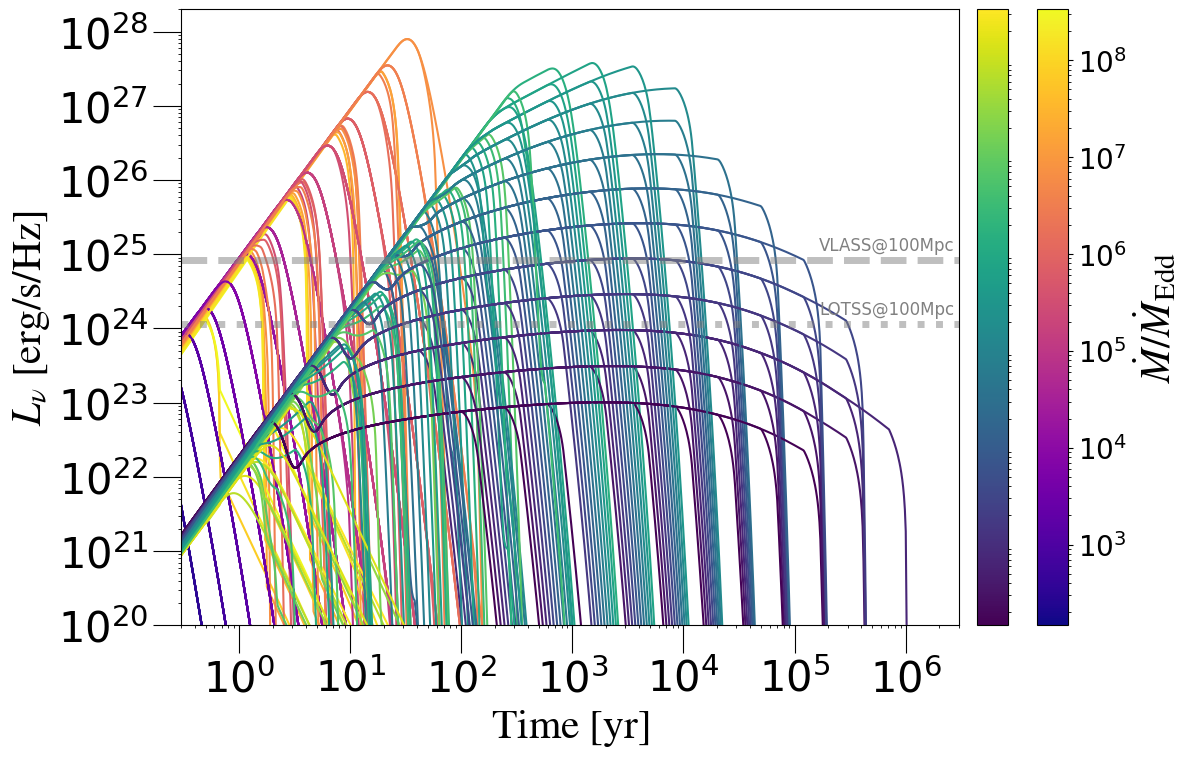

In [11]:
fig, ax = plt.subplots(figsize = (13,8))

color_values = lc_table_01_01['Mdot']
cmap1 = plt.get_cmap('plasma')
cmap2 = plt.get_cmap('viridis')
norm = LogNorm(vmin=min(color_values), vmax=max(color_values))

lines1 = []
for i in range(len(lc_table_01_01)):
    line, =ax.plot(t[t <= 100*lc_table_01_01[i]['t_active']], smooth(lc_table_01_01[i]['vlass'])/nu_vlass,
                    color=cmap1(norm(color_values[i])))
    lines1.append(line)
    
lines2 = []
for i in range(len(lc_table_01_01)):
    line, =ax.plot(t[t <= 100*lc_table_01_01[i]['t_active']], smooth(lc_table_01_01[i]['lotss'])/nu_lotss,
                    color=cmap2(norm(color_values[i])))
    lines2.append(line)

sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax, pad=-0.08)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label=r'$\dot{M}/\dot{M}_{\mathrm{Edd}}$', fontsize=30)

sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax, pad=0.02)
cbar2.set_ticks([])

Lnu_100Mpc_vlass = 4*np.pi*(100*Mpc)**2*fnu_vlass
Lnu_100Mpc_lotss = 4*np.pi*(100*Mpc)**2*fnu_lotss

plt.axhline(Lnu_100Mpc_vlass, color='gray', ls='dashed', lw=5, alpha=0.5)
ax.text(ax.get_xlim()[1]*0.05, Lnu_100Mpc_vlass+0.5e25, 'VLASS@100Mpc', va='center', ha='left', fontsize=12, color='gray')


plt.axhline(Lnu_100Mpc_lotss, color='gray', ls='dotted', lw=5, alpha=0.5)
ax.text(ax.get_xlim()[1]*0.05, Lnu_100Mpc_lotss+0.7e24, 'LOTSS@100Mpc', va='center', ha='left', fontsize=12, color='gray')


ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.xscale('log')
plt.yscale('log')

plt.xlim([3e-1, 3e6])
plt.ylim([1.0e20, 2e28])

plt.xlabel(r'$\mathrm{Time \ [yr]}$', fontsize = 30)
plt.ylabel(r'$L_{\nu} \ \mathrm{[erg/s/Hz]}$', fontsize = 30)
plt.savefig('./figures/Lnu_01_01_comp.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

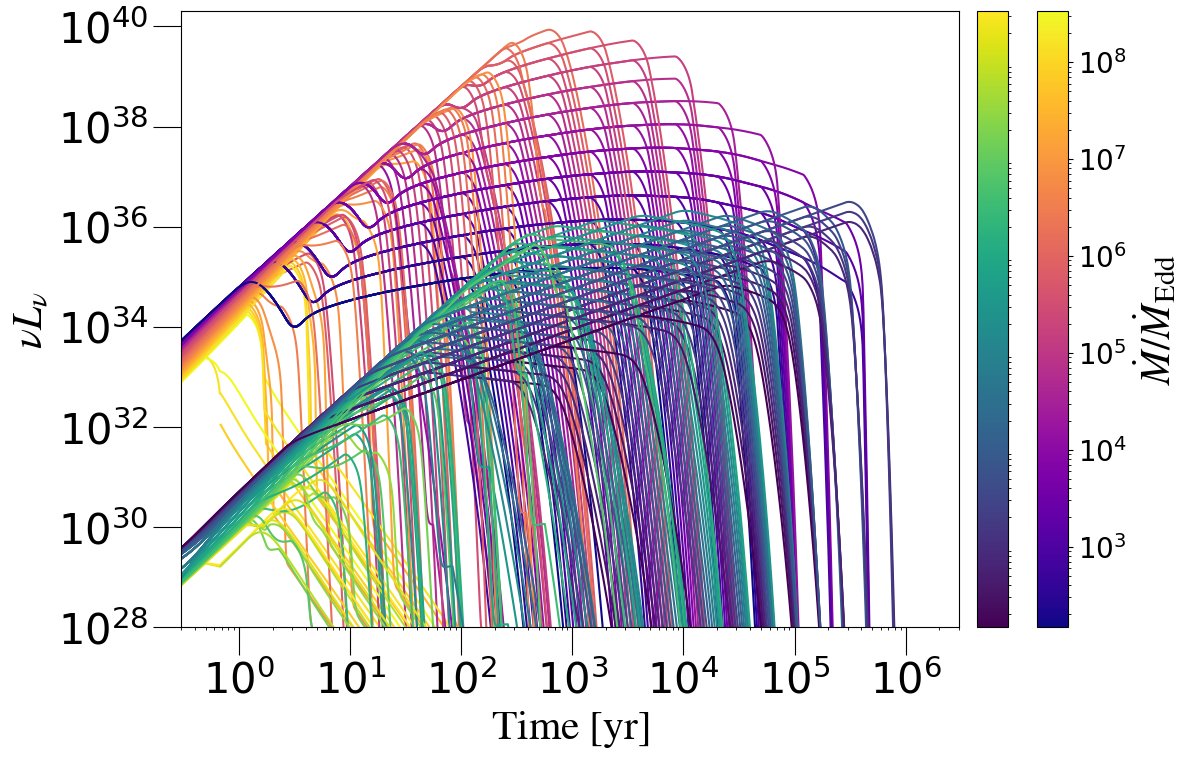

In [23]:
fig, ax = plt.subplots(figsize = (13,8))

color_values = lc_table_025_01['Mdot']
cmap1 = plt.get_cmap('plasma')
cmap2 = plt.get_cmap('viridis')
norm = LogNorm(vmin=min(color_values), vmax=max(color_values))

lines1 = []
for i in range(len(lc_table_025_01)):
    line, =ax.plot(t[t <= 100*lc_table_025_01[i]['t_active']], smooth(lc_table_025_01[i]['vlass']),
                    color=cmap1(norm(color_values[i])))
    lines1.append(line)
    
lines2 = []
for i in range(len(lc_table_025_01)):
    line, =ax.plot(t[t <= 100*lc_table_025_01[i]['t_active']], smooth(lc_table_025_01[i]['lotss']),
                    color=cmap2(norm(color_values[i])))
    lines2.append(line)

sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax, pad=-0.08)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label=r'$\dot{M}/\dot{M}_{\mathrm{Edd}}$', fontsize=30)

sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax, pad=0.02)
cbar2.set_ticks([])

ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.xscale('log')
plt.yscale('log')

plt.xlim([3e-1, 3e6])
plt.ylim([1e28, 2e40])

plt.xlabel(r'$\mathrm{Time \ [yr]}$', fontsize = 30)
plt.ylabel(r'$\nu L_{\nu}$', fontsize = 30)
plt.savefig('./figures/nuLnu_025_01_comp.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

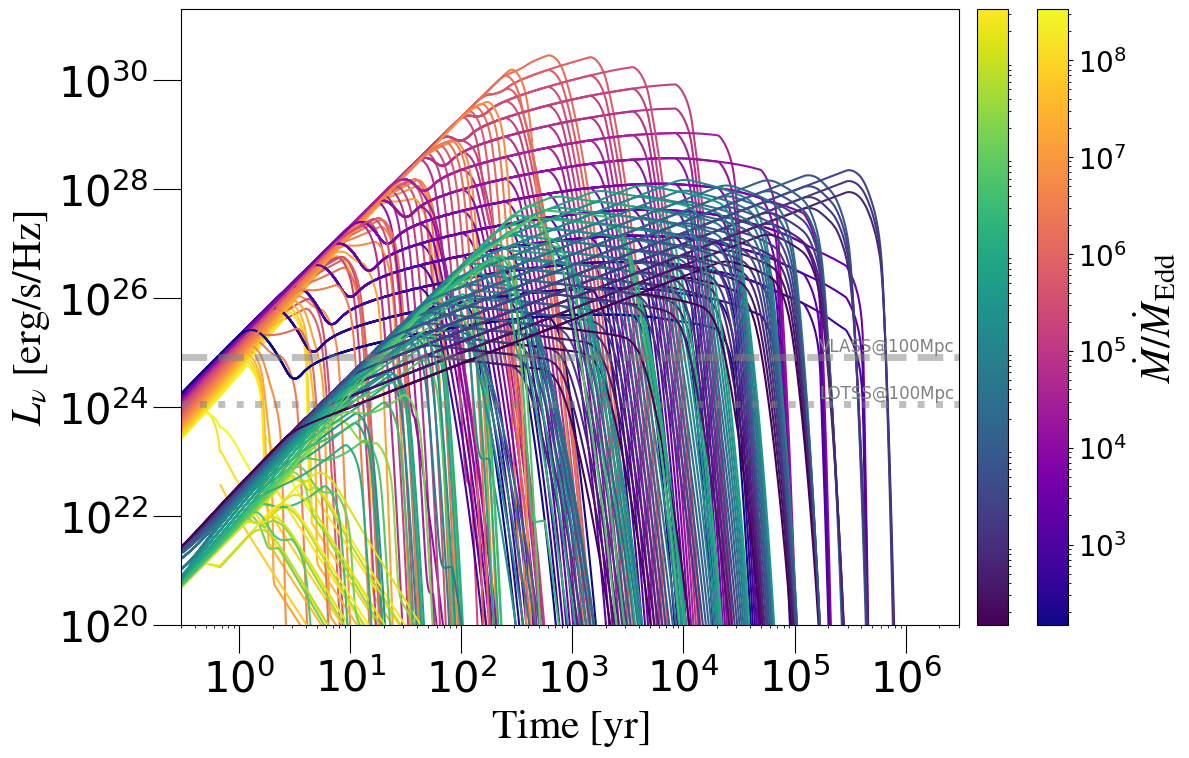

In [20]:
fig, ax = plt.subplots(figsize = (13,8))

color_values = lc_table_025_01['Mdot']
cmap1 = plt.get_cmap('plasma')
cmap2 = plt.get_cmap('viridis')
norm = LogNorm(vmin=min(color_values), vmax=max(color_values))

lines1 = []
for i in range(len(lc_table_025_01)):
    line, =ax.plot(t[t <= 100*lc_table_025_01[i]['t_active']], smooth(lc_table_025_01[i]['vlass'])/nu_vlass,
                    color=cmap1(norm(color_values[i])))
    lines1.append(line)
    
lines2 = []
for i in range(len(lc_table_025_01)):
    line, =ax.plot(t[t <= 100*lc_table_025_01[i]['t_active']], smooth(lc_table_025_01[i]['lotss'])/nu_lotss,
                    color=cmap2(norm(color_values[i])))
    lines2.append(line)

sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax, pad=-0.08)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label=r'$\dot{M}/\dot{M}_{\mathrm{Edd}}$', fontsize=30)

sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax, pad=0.02)
cbar2.set_ticks([])

Lnu_100Mpc_vlass = 4*np.pi*(100*Mpc)**2*fnu_vlass
Lnu_100Mpc_lotss = 4*np.pi*(100*Mpc)**2*fnu_lotss

plt.axhline(Lnu_100Mpc_vlass, color='gray', ls='dashed', lw=5, alpha=0.5)
ax.text(ax.get_xlim()[1]*0.05, Lnu_100Mpc_vlass+0.5e25, 'VLASS@100Mpc', va='center', ha='left', fontsize=12, color='gray')


plt.axhline(Lnu_100Mpc_lotss, color='gray', ls='dotted', lw=5, alpha=0.5)
ax.text(ax.get_xlim()[1]*0.05, Lnu_100Mpc_lotss+0.7e24, 'LOTSS@100Mpc', va='center', ha='left', fontsize=12, color='gray')


ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.xscale('log')
plt.yscale('log')

plt.xlim([3e-1, 3e6])
plt.ylim([1.0e20, 2e31])

plt.xlabel(r'$\mathrm{Time \ [yr]}$', fontsize = 30)
plt.ylabel(r'$L_{\nu} \ \mathrm{[erg/s/Hz]}$', fontsize = 30)
plt.savefig('./figures/Lnu_025_01_comp.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()